In [1]:
# Set your working directory
import sys
sys.path.insert(0, "../models/")

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
%matplotlib notebook

In [4]:
from HMM import HMM
from posteriors import gamma, dirichlet, simul_s, _poisson

# The lamb fetal dataset

In [5]:
Y = pd.read_csv("../dataset/lamb.csv", index_col = 0).values.flatten() # Load the dataset

<IPython.core.display.Javascript object>


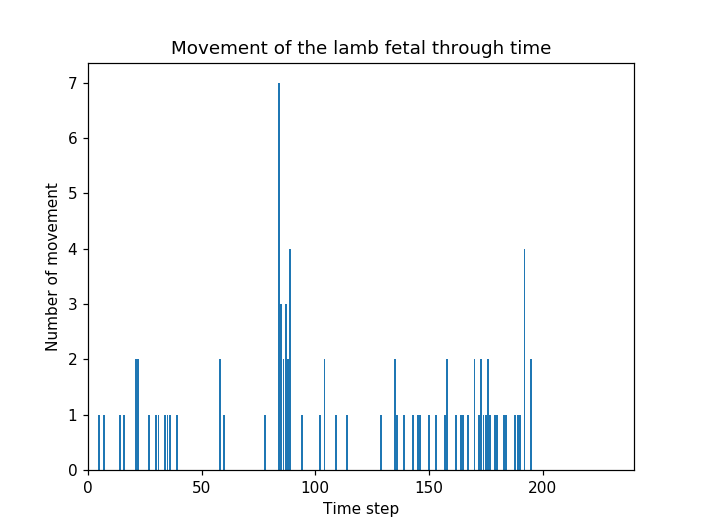

Text(0.5,0,'Time step')

In [6]:
plt.figure()
plt.bar(range(len(Y)), Y)
plt.title("Movement of the lamb fetal through time")
plt.xlim(0, len(Y))
plt.ylabel("Number of movement")
plt.xlabel("Time step")

# We will fit a two component poisson HMM

A 2 components poisson HMM is made of :
* A posterior `gamma` distribution over $\theta = \lambda \in IR^2$
* A posterior distribution over $S \in IR^n$, the states vector; where $n = #obs$
* A posterior `dirichlet` distribution over the transition matrix $P \in IR^{2x2}$

We start by defining the posterior of $ \lambda$

In [7]:
tDictDist = {"_lambda": gamma()}
tDictDist["_lambda"]._set_default(a = np.array([1, 2]))
tDictDist["_lambda"]._set_default(scale = np.array([1/2, 1]))

Now, the **S** distribtuion ...

In [8]:
sDist = simul_s(func = _poisson) # S distribution

Now the $P$ distribution

In [9]:
pDist = dirichlet() # A dirichlet distribution is common for probability vectors
pDist._set_default(a = np.array([[3,1], [0.5,0.5]]))

# Running the HMM

In [10]:
Theta = {"_lambda" : np.array([0.5, 2])} # Initial lambdas, any !
S = np.random.choice(2, len(Y)) # Initial S, random !
P = np.array([[0.75,0.25],[0.5,0.5]]) # Initial P, any !

In [11]:
np.random.seed(111)
phmm = HMM(tDictDist, sDist, pDist, Y=Y, S = S, Theta = Theta, P = P )

In [12]:
np.random.seed(111)
phmm.run(5000, historise = True) # Start the gibbs sampler n-times

Time : 2019-01-30  23:13:55   Elapsed : 0.00 min.  N_iter : 0000   Remain : 5000   %Remain : 100%
Time : 2019-01-30  23:14:13   Elapsed : 0.30 min.  N_iter : 0500   Remain : 4500   %Remain : 90%
Time : 2019-01-30  23:14:35   Elapsed : 0.67 min.  N_iter : 1000   Remain : 4000   %Remain : 80%
Time : 2019-01-30  23:14:58   Elapsed : 1.04 min.  N_iter : 1500   Remain : 3500   %Remain : 70%
Time : 2019-01-30  23:15:14   Elapsed : 1.31 min.  N_iter : 2000   Remain : 3000   %Remain : 60%
Time : 2019-01-30  23:15:30   Elapsed : 1.58 min.  N_iter : 2500   Remain : 2500   %Remain : 50%
Time : 2019-01-30  23:15:46   Elapsed : 1.85 min.  N_iter : 3000   Remain : 2000   %Remain : 40%
Time : 2019-01-30  23:16:05   Elapsed : 2.17 min.  N_iter : 3500   Remain : 1500   %Remain : 30%
Time : 2019-01-30  23:16:25   Elapsed : 2.51 min.  N_iter : 4000   Remain : 1000   %Remain : 19%
Time : 2019-01-30  23:16:42   Elapsed : 2.78 min.  N_iter : 4500   Remain : 0500   %Remain : 09%


## Checking for auto-correlation in the chain

<IPython.core.display.Javascript object>


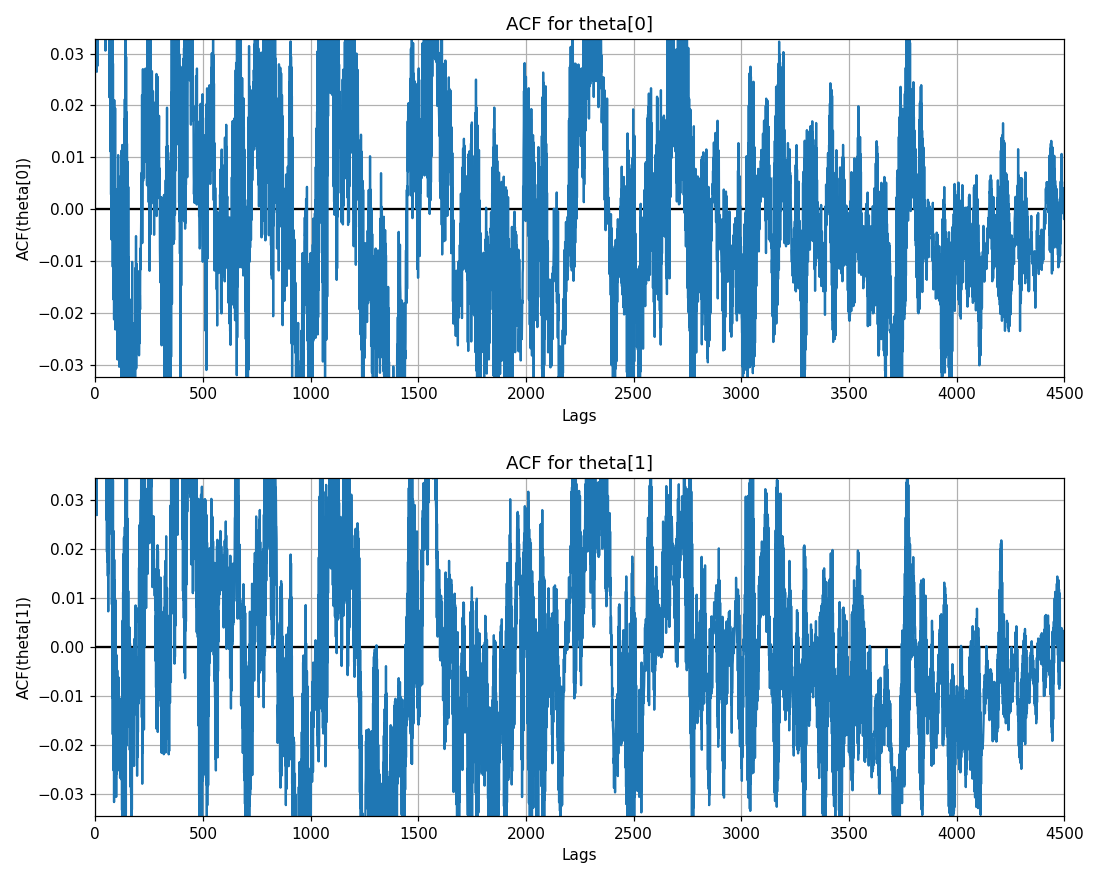

In [13]:
from utils import plot_ACF

lambdas = np.array([x["_lambda"] for x in phmm.H["Theta"]])

plot_ACF(lambdas, nlags = 4500)

The ACF is not converging toward zero. It seems the chain is not good. However, you can see below that we get the same results has in the paper. Maybe the ACF is not accurate for this model.

# Can we recover the clusters ? Let's see !

<IPython.core.display.Javascript object>


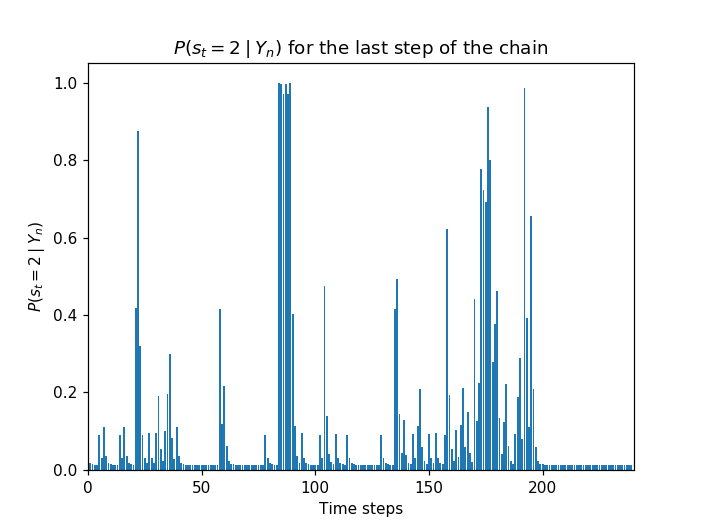

Text(0.5,1,'$P(s_t = 2\\:|\\:Y_n)$ for the last step of the chain')

In [14]:
plt.figure()
plt.bar(range(sDist.F.shape[0]), sDist.F[:, 1])
plt.xlim(0, 240)
plt.ylabel("$P(s_t = 2\:|\:Y_n)$")
plt.xlabel("Time steps")
plt.title("$P(s_t = 2\:|\:Y_n)$ for the last step of the chain")

As expected, we get the same results as in the paper.

# The posteriors

## Lambdas

In [15]:
pd.DataFrame(lambdas[500:], columns = ["lambda1", "lambda2"])\
            .describe().drop("count", axis=0)

,lambda1,lambda2
mean,0.221981,2.314702
std,0.049016,0.768424
min,0.010608,0.506923
25%,0.190925,1.758515
50%,0.221947,2.212201
75%,0.255175,2.793433
max,0.388283,6.587918


## Transition probabilities (P)

In [16]:
pd.DataFrame(np.array(phmm.H["P"])[500:, [0,1], [0,1]], columns = ["p11", "p22"])\
            .describe().drop("count", axis=0)

,p11,p22
mean,0.969730,0.672716
std,0.021177,0.153918
min,0.853894,0.106732
25%,0.959901,0.572867
50%,0.974775,0.687084
75%,0.984783,0.786369
max,0.999861,0.990304


# Conclusion

We get the same results has in the paper. However it seems the ACF is not good. The chain is too much correlated. There is no way to check if it was also the case in the paper.